In [2]:
import torch
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


def get_rays(datapath, mode="train"):
    pose_file_names = [
        f for f in os.listdir(datapath + f"/{mode}/pose") if f.endswith(".txt")
    ]
    intrisics_file_names = [
        f for f in os.listdir(datapath + f"/{mode}/intrinsics") if f.endswith(".txt")
    ]
    img_file_names = [f for f in os.listdir(datapath + "/imgs") if mode in f]
    print(
        f"Found {len(pose_file_names)} poses, {len(intrisics_file_names)} intrinsics, and {len(img_file_names)} images."
    )

    assert len(pose_file_names) == len(intrisics_file_names)
    assert len(img_file_names) == len(pose_file_names)

    # Read
    N = len(pose_file_names)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))

    images = []

    for i in range(N):
        name = pose_file_names[i]

        pose = open(datapath + f"/{mode}/pose/" + name).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4, 4)

        intrinsic = open(datapath + f"/{mode}/intrinsics/" + name).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4, 4)

        # Read images
        img = imageio.imread(datapath + "/imgs/" + name.replace("txt", "png")) / 255.0
        images.append(img[None, ...])
    images = np.concatenate(images)

    H = images.shape[1]
    W = images.shape[2]

    if images.shape[3] == 4:  # RGBA -> RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    rays_o = np.zeros((N, H * W, 3))
    rays_d = np.zeros((N, H * W, 3))
    target_px_values = images.reshape((N, H * W, 3))

    for i in range(N):
        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), -np.ones_like(u) * f), axis=-1)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)

        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values


In [3]:
batch_size = 1024

o, d, target_px_values = get_rays("./fox", mode="train")
dataloader = DataLoader(
    torch.cat(
        (torch.from_numpy(o), torch.from_numpy(d),
        torch.from_numpy(target_px_values)),
        dim=1,
    ),
    batch_size=batch_size,
    shuffle=True,
)
test_o, test_d, test_target_px_values = get_rays("./fox", mode="test")

dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3),
                                   torch.from_numpy(d).reshape(-1, 3),
                                   torch.from_numpy(target_px_values).reshape(-1, 3)), dim=1),
                       batch_size=batch_size, shuffle=True)


dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3)), dim=1),
                       batch_size=batch_size, shuffle=True)


Found 90 poses, 90 intrinsics, and 90 images.


C:\Users\super\AppData\Local\Temp\ipykernel_47524\3461003220.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + "/imgs/" + name.replace("txt", "png")) / 255.0


Found 10 poses, 10 intrinsics, and 10 images.


In [15]:
test_o.shape

(10, 160000, 3)

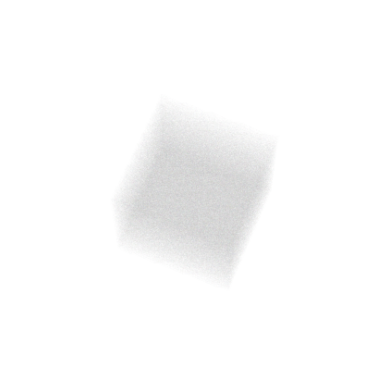

In [6]:
import matplotlib.pyplot as plt
import torch
from model import Voxels
import numpy as np
from rendering import rendering

model = Voxels(scale=1)

# Assuming o and d are previously defined arrays/tensors
img = rendering(model, torch.from_numpy(o[-1]), torch.from_numpy(d[-1]), 8, 12)

# Detach the tensor from the graph and move it to CPU for visualization
img_np = img.detach().cpu().numpy()

plt.imshow(img_np.reshape(400, 400, 3))
plt.axis("off")
plt.show()


  0%|          | 0/3516 [00:00<?, ?it/s]c:\Users\super\Documents\Github\sequoia\Nerf\ml_helpers.py:22: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  training_loss.append(loss.item())
100%|██████████| 3516/3516 [00:49<00:00, 71.00it/s]


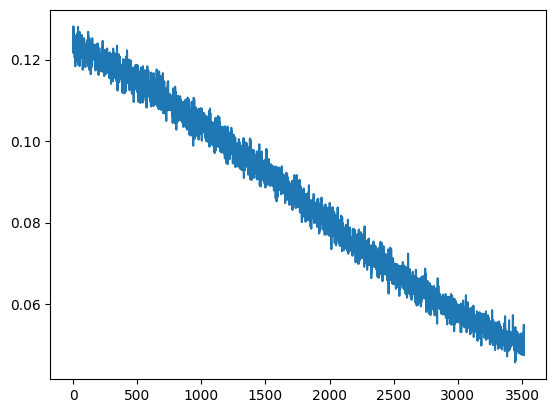

 72%|███████▏  | 10128/14063 [04:04<01:34, 41.45it/s]


KeyboardInterrupt: 

In [17]:
from ml_helpers import training


device = 'cuda'

tn = 8
tf = 12
nb_epochs = 15
lr = 1e-3
gamma = .5
nb_bins = 100

model = Voxels(scale=3, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

In [7]:

img = rendering(model, torch.from_numpy(o[0]).to(device), torch.from_numpy(d[0]).to(device), 
                tn, tf, nb_bins=10 0, device=device)
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

SyntaxError: invalid syntax. Perhaps you forgot a comma? (874545773.py, line 2)

In [ ]:

img = rendering(model, torch.from_numpy(o[2]).to(device), torch.from_numpy(d[2]).to(device), 
                tn, tf, nb_bins=100, device=device)
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

In [ ]:

img = rendering(model, torch.from_numpy(o[3]).to(device), torch.from_numpy(d[3]).to(device), 
                tn, tf, nb_bins=100, device=device)
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

In [9]:
from model import Nerf
from ml_helpers import training

device = 'cuda'

tn = 8.
tf = 12.
nb_epochs = 10
lr = 1e-3
gamma = .5
nb_bins = 100

model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

  0%|          | 0/3516 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float